# Setup and Imports

Install required libraries and import modules for dataset processing, model training, and app functionality.

**Note**: Run `!pip install ...` in Colab or ensure dependencies are installed locally.

In [2]:
pip install tensorflow opencv-python numpy pandas scikit-learn matplotlib pygame mediapipe

  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
  Using cached mediapipe-0.10.21-cp310-cp310-win_amd64.whl.metadata (10 kB)
Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl (375.7 MB)
Using cached mediapipe-0.10.21-cp310-cp310-win_amd64.whl (51.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries for data processing and model training
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Import libraries for app functionality
import random
import os
import pygame
import time
from tkinter import Tk, Label, Button, StringVar, Scale, HORIZONTAL, Frame
from threading import Thread
import mediapipe as mp
from collections import deque

# Ensure matplotlib works in Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

print("Libraries imported successfully!")

pygame 2.6.1 (SDL 2.28.4, Python 3.10.16)
Hello from the pygame community. https://www.pygame.org/contribute.html
Libraries imported successfully!


# Load FER2013 Dataset

Loads the FER2013 dataset from `data/fer2013.csv`, containing ~35,887 grayscale 48x48 images labeled with 7 emotions (Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral).

**Ensure**: `data/fer2013.csv` is in place. In Colab, upload or use Kaggle API.

In [2]:
import pandas as pd
import numpy as np

def load_fer2013_chunked(data_path='data/fer2013.csv', chunksize=5000):
    """Load FER2013 dataset in chunks to reduce memory usage."""
    images = []
    labels = []

    try:
        # Read CSV in chunks
        for chunk in pd.read_csv(data_path, chunksize=chunksize):
            # Process pixels
            chunk_pixels = chunk['pixels'].apply(lambda x: np.array(x.split(), dtype='float32'))
            chunk_images = np.array([pixel.reshape(48, 48, 1) for pixel in chunk_pixels]) / 255.0  # Normalize
            chunk_labels = chunk['emotion'].values

            # Append to lists
            images.append(chunk_images)
            labels.append(chunk_labels)

            print(f"Processed chunk of {len(chunk)} images. Total: {len(np.concatenate(labels))}")

        # Concatenate all chunks
        images = np.concatenate(images, axis=0)
        labels = np.concatenate(labels, axis=0)

        print(f"Loaded {len(images)} images with shape {images.shape}")
        return images, labels

    except FileNotFoundError:
        print(f"Error: {data_path} not found. Please download from Kaggle.")
        return None, None
    except Exception as e:
        print(f"Error processing dataset: {e}")
        return None, None

# Load dataset
images, labels = load_fer2013_chunked()
if images is None:
    raise SystemExit("Dataset loading failed.")

Processed chunk of 5000 images. Total: 5000
Processed chunk of 5000 images. Total: 10000
Processed chunk of 5000 images. Total: 15000
Processed chunk of 5000 images. Total: 20000
Processed chunk of 5000 images. Total: 25000
Processed chunk of 5000 images. Total: 30000
Processed chunk of 5000 images. Total: 35000
Processed chunk of 887 images. Total: 35887
Loaded 35887 images with shape (35887, 48, 48, 1)


# Preprocess Data and Setup Augmentation

Splits data into training and validation sets, applies one-hot encoding, and configures data augmentation to improve model robustness (rotation, zoom, flips).

Train: (28709, 48, 48, 1), Validation: (7178, 48, 48, 1)


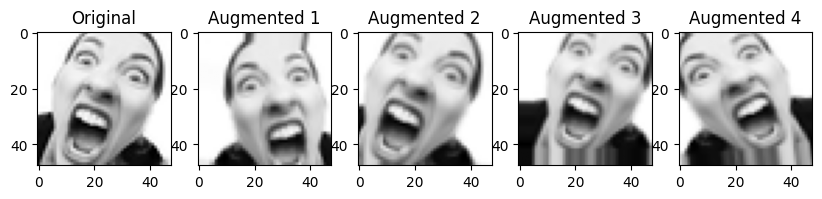

In [3]:
def preprocess_data(images, labels):
    """Split data and one-hot encode labels."""
    # Split into train (80%) and validation (20%)
    X_train, X_val, y_train, y_val = train_test_split(
        images, labels, test_size=0.2, stratify=labels, random_state=42
    )
    # One-hot encode labels
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y_train)
    y_val = lb.transform(y_val)
    print(f"Train: {X_train.shape}, Validation: {X_val.shape}")
    return X_train, X_val, y_train, y_val

# Preprocess data
X_train, X_val, y_train, y_val = preprocess_data(images, labels)

# Setup data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Visualize augmentation (optional)
sample_image = X_train[0].reshape(48, 48)
plt.figure(figsize=(10, 2))
plt.subplot(1, 5, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original")
for i in range(4):
    aug_iter = datagen.flow(X_train[0:1], batch_size=1)
    aug_image = next(aug_iter)[0].reshape(48, 48)
    plt.subplot(1, 5, i+2)
    plt.imshow(aug_image, cmap='gray')
    plt.title(f"Augmented {i+1}")
plt.show()

# Build and Train CNN Model

Defines a CNN architecture with augmentation and trains it on FER2013. Saves the best model to `models/emotion_model.h5`.

**Note**: Training may take ~20 min on GPU, longer on CPU. Use Colab for faster results.

In [32]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model():
    """Define CNN architecture for emotion detection."""
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create models directory
if not os.path.exists('models'):
    os.makedirs('models')

# Train model
model = build_model()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('models/emotion_model.h5', save_best_only=True, monitor='val_accuracy', save_weights_only=False)
]

# Assume X_train, y_train, X_val, y_val, datagen are defined from previous cells
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=callbacks
)

# Save model with optimizer state
model.save('models/emotion_model.h5', include_optimizer=True)

print("Model saved to models/emotion_model.h5")

Epoch 1/50


d:\Sugam\Pratik Project\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Sugam\Pratik Project\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.2382 - loss: 2.3633

449/449 ━━━━━━━━━━━━━━━━━━━━ 160s 352ms/step - accuracy: 0.2382 - loss: 2.3626 - val_accuracy: 0.2303 - val_loss: 2.2294
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.3631 - loss: 1.6457

449/449 ━━━━━━━━━━━━━━━━━━━━ 160s 357ms/step - accuracy: 0.3632 - loss: 1.6456 - val_accuracy: 0.2647 - val_loss: 1.8796
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.4297 - loss: 1.4710

449/449 ━━━━━━━━━━━━━━━━━━━━ 159s 353ms/step - accuracy: 0.4298 - loss: 1.4709 - val_accuracy: 0.4738 - val_loss: 1.4048
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.4768 - loss: 1.3751

449/449 ━━━━━━━━━━━━━━━━━━━━ 158s 352ms/step - accuracy: 0.4768 - loss: 1.3751 - val_accuracy: 0.4769 - val_loss: 1.3705
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.4895 - loss: 1.3348

449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 345ms/step - accuracy: 0.4895 - loss: 1.3348 - val_accuracy: 0.5061 - val_loss: 1.3133
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.5004 - loss: 1.3104

449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 345ms/step - accuracy: 0.5004 - loss: 1.3104 - val_accuracy: 0.5581 - val_loss: 1.1589
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 154s 344ms/step - accuracy: 0.5141 - loss: 1.2706 - val_accuracy: 0.5479 - val_loss: 1.1922
Epoch 8/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 346ms/step - accuracy: 0.4942 - loss: 1.3252 - val_accuracy: 0.4993 - val_loss: 1.4116
Epoch 9/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 154s 344ms/step - accuracy: 0.5217 - loss: 1.2627 - val_accuracy: 0.4654 - val_loss: 1.5764
Epoch 10/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.5292 - loss: 1.2331

449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 345ms/step - accuracy: 0.5292 - loss: 1.2331 - val_accuracy: 0.5635 - val_loss: 1.1679
Epoch 11/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.5334 - loss: 1.2288

449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 346ms/step - accuracy: 0.5334 - loss: 1.2288 - val_accuracy: 0.5942 - val_loss: 1.0818
Epoch 12/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 345ms/step - accuracy: 0.5489 - loss: 1.1990 - val_accuracy: 0.5245 - val_loss: 1.3867
Epoch 13/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 345ms/step - accuracy: 0.5488 - loss: 1.1870 - val_accuracy: 0.5655 - val_loss: 1.2194
Epoch 14/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 347ms/step - accuracy: 0.5476 - loss: 1.1891 - val_accuracy: 0.4606 - val_loss: 1.8198
Epoch 15/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 345ms/step - accuracy: 0.5457 - loss: 1.2076 - val_accuracy: 0.5711 - val_loss: 1.1397
Epoch 16/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 346ms/step - accuracy: 0.5564 - loss: 1.1689 - val_accuracy: 0.5712 - val_loss: 1.1525
Epoch 17/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 346ms/step - accuracy: 0.5526 - loss: 1.1723 - val_accuracy: 0.5876 - val_loss: 1.0832
Epoch 18/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 346ms/step - accuracy: 0.5619 - los

449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 348ms/step - accuracy: 0.5706 - loss: 1.1490 - val_accuracy: 0.6092 - val_loss: 1.0531
Epoch 20/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 347ms/step - accuracy: 0.5685 - loss: 1.1415 - val_accuracy: 0.4221 - val_loss: 1.7724
Epoch 21/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 345ms/step - accuracy: 0.5717 - loss: 1.1427 - val_accuracy: 0.5942 - val_loss: 1.0840
Epoch 22/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 346ms/step - accuracy: 0.5707 - loss: 1.1299 - val_accuracy: 0.6034 - val_loss: 1.0631
Epoch 23/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.5750 - loss: 1.1217

449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 348ms/step - accuracy: 0.5750 - loss: 1.1217 - val_accuracy: 0.6094 - val_loss: 1.0493
Epoch 24/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 346ms/step - accuracy: 0.5787 - loss: 1.1138 - val_accuracy: 0.6094 - val_loss: 1.1160
Epoch 25/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 347ms/step - accuracy: 0.5768 - loss: 1.1086 - val_accuracy: 0.5709 - val_loss: 1.2158
Epoch 26/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.5906 - loss: 1.0909

449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 347ms/step - accuracy: 0.5906 - loss: 1.0910 - val_accuracy: 0.6230 - val_loss: 1.0207
Epoch 27/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 347ms/step - accuracy: 0.5902 - loss: 1.0876 - val_accuracy: 0.5396 - val_loss: 1.2265
Epoch 28/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 346ms/step - accuracy: 0.5760 - loss: 1.1123 - val_accuracy: 0.5965 - val_loss: 1.0935
Epoch 29/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 346ms/step - accuracy: 0.5922 - loss: 1.0792 - val_accuracy: 0.5805 - val_loss: 1.1170
Epoch 30/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 347ms/step - accuracy: 0.5956 - loss: 1.0807 - val_accuracy: 0.6076 - val_loss: 1.0500
Epoch 31/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 347ms/step - accuracy: 0.5978 - loss: 1.0645 - val_accuracy: 0.6028 - val_loss: 1.1402
Epoch 32/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 347ms/step - accuracy: 0.5965 - loss: 1.0645 - val_accuracy: 0.6055 - val_loss: 1.0777
Epoch 33/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 347ms/step - accuracy: 0.5987 - los

449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 347ms/step - accuracy: 0.5994 - loss: 1.0645 - val_accuracy: 0.6305 - val_loss: 0.9966
Epoch 35/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 346ms/step - accuracy: 0.6060 - loss: 1.0452 - val_accuracy: 0.6220 - val_loss: 1.0697
Epoch 36/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 346ms/step - accuracy: 0.6080 - loss: 1.0426 - val_accuracy: 0.6197 - val_loss: 1.0464
Epoch 37/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.6118 - loss: 1.0302

449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 348ms/step - accuracy: 0.6118 - loss: 1.0302 - val_accuracy: 0.6375 - val_loss: 1.0020
Epoch 38/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 348ms/step - accuracy: 0.6113 - loss: 1.0229 - val_accuracy: 0.5896 - val_loss: 1.1878
Epoch 39/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 348ms/step - accuracy: 0.6090 - loss: 1.0414 - val_accuracy: 0.6374 - val_loss: 1.0098
Epoch 40/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 348ms/step - accuracy: 0.6174 - loss: 1.0277 - val_accuracy: 0.6311 - val_loss: 0.9986
Epoch 41/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 348ms/step - accuracy: 0.6068 - loss: 1.0420 - val_accuracy: 0.6346 - val_loss: 0.9812
Epoch 42/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 348ms/step - accuracy: 0.6092 - loss: 1.0346 - val_accuracy: 0.5943 - val_loss: 1.1063
Epoch 43/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 157s 349ms/step - accuracy: 0.6132 - loss: 1.0234 - val_accuracy: 0.5939 - val_loss: 1.1625
Epoch 44/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 348ms/step - accuracy: 0.6208 - los

449/449 ━━━━━━━━━━━━━━━━━━━━ 154s 343ms/step - accuracy: 0.6249 - loss: 0.9940 - val_accuracy: 0.6397 - val_loss: 0.9704
Epoch 50/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.6326 - loss: 0.9683

449/449 ━━━━━━━━━━━━━━━━━━━━ 154s 342ms/step - accuracy: 0.6326 - loss: 0.9683 - val_accuracy: 0.6452 - val_loss: 0.9676


Model saved to models/emotion_model.h5


# Custom Emotion Detection Function

Defines a function to detect emotions from webcam frames using the trained model. Replaces DeepFace in the app.

In [5]:
# Code
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

def preprocess_frame(frame, target_size=(48, 48)):
    """Preprocess a frame for emotion detection with robust face detection."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    h, w = frame.shape[:2]

    # Initialize MediaPipe face detection
    mp_face_detection = mp.solutions.face_detection
    with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detection:
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_detection.process(rgb_frame)
        if results.detections:
            detection = results.detections[0]
            bbox = detection.location_data.relative_bounding_box
            # Convert relative to absolute coordinates
            x = int(bbox.xmin * w)
            y = int(bbox.ymin * h)
            width = int(bbox.width * w)
            height = int(bbox.height * h)

            # Validate and clip coordinates
            x = max(0, min(x, w-1))
            y = max(0, min(y, h-1))
            width = max(1, min(width, w-x))
            height = max(1, min(height, h-y))

            print(f"Debug: MediaPipe bbox - x: {x}, y: {y}, width: {width}, height: {height}")

            # Extract face region
            try:
                face = gray[y:y+height, x:x+width]
                if face.size == 0:
                    print("Debug: Face region is empty after extraction.")
                    return None
                face = cv2.resize(face, target_size)
                face = face.astype('float32') / 255.0
                face = face.reshape(1, 48, 48, 1)
                print("Debug: Face preprocessed successfully.")
                return face
            except Exception as e:
                print(f"Debug: Error preprocessing face: {e}")
                return None
        else:
            # Try Haar Cascade as fallback
            print("Debug: No face detected with MediaPipe. Trying Haar...")
            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3, minSize=(30, 30))

            if len(faces) > 0:
                print("Debug: Face detected with Haar Cascade.")
                (x, y, w, h) = faces[0]
                try:
                    face = gray[y:y+h, x:x+w]
                    if face.size == 0:
                        print("Debug: Haar face region is empty.")
                        return None
                    face = cv2.resize(face, target_size)
                    face = face.astype('float32') / 255.0
                    face = face.reshape(1, 48, 48, 1)
                    print("Debug: Face preprocessed successfully.")
                    return face
                except Exception as e:
                    print(f"Debug: Error preprocessing Haar face: {e}")
                    return None
            else:
                print("Debug: No faces detected by either method.")
                return None

def detect_emotion_with_custom_model(frame):
    """Detect emotion using the custom model."""
    try:
        model = load_model('models/emotion_model.h5')
        # Compile as fallback if model wasn't saved with optimizer
        model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
        emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

        processed_frame = preprocess_frame(frame)
        if processed_frame is None:
            return "Neutral"

        prediction = model.predict(processed_frame, verbose=0)
        probabilities = prediction[0]
        dominant_emotion = emotion_labels[np.argmax(probabilities)]
        print(f"Debug: Probabilities: {probabilities}")
        print(f"Debug: Predicted emotion: {dominant_emotion}")

        return dominant_emotion
    except Exception as e:
        print(f"Custom model error: {e}")
        return "Neutral"

# Test the function with enhanced debugging
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Cannot open webcam. Try index 1 or check connection.")
else:
    ret, frame = cap.read()
    if ret:
        print("Debug: Webcam frame captured successfully.")
        mood = detect_emotion_with_custom_model(frame)
        print(f"Test detection: {mood}")
    else:
        print("Error: Failed to capture frame from webcam.")
    cap.release()
cv2.destroyAllWindows()

Debug: Webcam frame captured successfully.


Debug: MediaPipe bbox - x: 284, y: 193, width: 134, height: 134
Debug: Face preprocessed successfully.
Debug: Probabilities: [9.0122700e-02 4.1191979e-05 6.3502207e-02 2.0463254e-02 4.5105481e-01
 9.8253163e-03 3.6499047e-01]
Debug: Predicted emotion: Sad
Test detection: Sad


# Mood-Based Music Player with Custom Model

Integrates the custom emotion detection model into your gesture-controlled music player. Replaces DeepFace while preserving all functionality.

**Note**: Update `song_folder` if running in Colab (e.g., mount Google Drive).

In [ ]:
# Paths
song_folder = r"C:\Users\Ayush\Downloads\songs"  # Update for Colab if needed

# Global variables
current_song = None
detected_mood = "Neutral"
music_playing = False
music_paused = False
exit_flag = False
current_volume = 0.5
gesture_detection_enabled = True

# Initialize MediaPipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.6,
    min_tracking_confidence=0.6
)

# Initialize pygame mixer
pygame.mixer.init()

# Emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Face classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Gesture tracking variables
prev_hand_positions = deque(maxlen=10)
swipe_threshold = 0.15
pinch_distances = deque(maxlen=5)
last_gesture_time = 0
gesture_cooldown = 0.8
current_gesture = "None"
debug_info = {}

class GestureState:
    def __init__(self):
        self.swipe_start_x = None
        self.swipe_in_progress = False
        self.palm_shown = False
        self.thumbs_up_shown = False
        self.fist_shown = False
        self.pinch_reference = None
        self.last_recognized_gesture = None

gesture_state = GestureState()

def detect_mood():
    global detected_mood
    cap = cv2.VideoCapture(0)
    status_var.set("Detecting Mood...")
    mood_var.set("Detecting...")
    update_mood_color("gray")

    with mp_face_mesh.FaceMesh(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as face_mesh:

        start_time = time.time()
        mood_counts = {}

        while time.time() - start_time < 5:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.flip(frame, 1)
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            rgb_frame.flags.writeable = False
            results = face_mesh.process(rgb_frame)
            rgb_frame.flags.writeable = True
            frame = cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2BGR)

            current_mood = detect_emotion_with_custom_model(frame)
            if current_mood in mood_counts:
                mood_counts[current_mood] += 1
            else:
                mood_counts[current_mood] = 1

            detected_mood = current_mood
            mood_var.set(f"Mood: {detected_mood}")
            update_mood_color(detected_mood)

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 5)
            for (x, y, w, h) in faces:
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

            cv2.putText(frame, f"Detecting mood: {detected_mood}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            progress = min(100, int((time.time() - start_time) / 5 * 100))
            cv2.rectangle(frame, (10, 50), (10 + int(progress * 2), 70), (0, 255, 0), -1)
            cv2.rectangle(frame, (10, 50), (210, 70), (255, 255, 255), 2)
            cv2.putText(frame, f"{progress}%", (215, 65),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

            cv2.imshow("Mood Detector", frame)
            if cv2.waitKey(5) & 0xFF == ord('q'):
                break

        if mood_counts:
            detected_mood = max(mood_counts, key=mood_counts.get)

        status_var.set(f"Mood detected: {detected_mood}")
        print(f"Final Mood Detected: {detected_mood}")

    cap.release()
    cv2.destroyAllWindows()

def calculate_hand_features(landmarks, frame_width, frame_height):
    wrist = landmarks[0]
    thumb_tip = landmarks[4]
    index_tip = landmarks[8]
    middle_tip = landmarks[12]
    ring_tip = landmarks[16]
    pinky_tip = landmarks[20]

    palm_points = [landmarks[0], landmarks[5], landmarks[9], landmarks[13], landmarks[17]]
    palm_x = sum(point.x for point in palm_points) / len(palm_points)
    palm_y = sum(point.y for point in palm_points) / len(palm_points)
    palm_z = sum(point.z for point in palm_points) / len(palm_points)

    thumb_tip_coord = (thumb_tip.x * frame_width, thumb_tip.y * frame_height)
    index_tip_coord = (index_tip.x * frame_width, index_tip.y * frame_height)
    palm_center = (palm_x * frame_width, palm_y * frame_height)

    pinch_distance = ((thumb_tip.x - index_tip.x) ** 2 +
                      (thumb_tip.y - index_tip.y) ** 2) ** 0.5

    fingertips_to_palm = [
        ((tip.x - palm_x) ** 2 + (tip.y - palm_y) ** 2) ** 0.5
        for tip in [thumb_tip, index_tip, middle_tip, ring_tip, pinky_tip]
    ]

    finger_heights = [
        wrist.y - tip.y
        for tip in [thumb_tip, index_tip, middle_tip, ring_tip, pinky_tip]
    ]

    palm_facing_camera = (middle_tip.z - wrist.z) < -0.05
    thumb_up = thumb_tip.y < wrist.y - 0.1
    avg_fingertip_z = sum(tip.z for tip in [thumb_tip, index_tip, middle_tip, ring_tip, pinky_tip]) / 5

    finger_curl_thresholds = [0.08, 0.06, 0.06, 0.06]
    fingers_curled = [
        abs(landmarks[4*i+3].y - landmarks[4*i+1].y) < finger_curl_thresholds[i-1]
        for i in range(1, 5)
    ]
    fist_detected = all(fingers_curled) and thumb_tip.x > index_tip.x

    return {
        "palm_center": palm_center,
        "pinch_distance": pinch_distance,
        "palm_facing_camera": palm_facing_camera,
        "thumb_up": thumb_up,
        "fingertips_to_palm": fingertips_to_palm,
        "finger_heights": finger_heights,
        "fist_detected": fist_detected,
        "thumb_tip": thumb_tip_coord,
        "index_tip": index_tip_coord,
        "avg_fingertip_z": avg_fingertip_z
    }

def detect_gestures(hand_features, frame_shape):
    global gesture_state, current_gesture, last_gesture_time, debug_info
    current_time = time.time()
    width, height = frame_shape[1], frame_shape[0]

    palm_center = hand_features["palm_center"]
    prev_hand_positions.append(palm_center)
    current_pinch = hand_features["pinch_distance"]
    pinch_distances.append(current_pinch)
    current_gesture = "None"

    debug_info = {
        "palm_facing": hand_features["palm_facing_camera"],
        "fist": hand_features["fist_detected"],
        "thumb_up": hand_features["thumb_up"],
        "pinch": round(current_pinch, 3)
    }

    if current_time - last_gesture_time < gesture_cooldown:
        return None

    if hand_features["palm_facing_camera"] and not gesture_state.palm_shown:
        current_gesture = "Palm Stop"
        gesture_state.palm_shown = True
        last_gesture_time = current_time
        return "palm_stop"

    if not hand_features["palm_facing_camera"] and gesture_state.palm_shown:
        gesture_state.palm_shown = False

    if hand_features["thumb_up"] and not hand_features["fist_detected"] and not gesture_state.thumbs_up_shown:
        current_gesture = "Thumbs Up"
        gesture_state.thumbs_up_shown = True
        last_gesture_time = current_time
        return "thumbs_up"

    if not hand_features["thumb_up"] and gesture_state.thumbs_up_shown:
        gesture_state.thumbs_up_shown = False

    if hand_features["fist_detected"] and not gesture_state.fist_shown:
        current_gesture = "Fist"
        gesture_state.fist_shown = True
        last_gesture_time = current_time
        return "fist"

    if not hand_features["fist_detected"] and gesture_state.fist_shown:
        gesture_state.fist_shown = False

    if len(prev_hand_positions) >= 5:
        oldest_pos = prev_hand_positions[0]
        newest_pos = prev_hand_positions[-1]
        x_distance = (newest_pos[0] - oldest_pos[0]) / width
        if abs(x_distance) > swipe_threshold:
            prev_hand_positions.clear()
            if x_distance > 0:
                current_gesture = "Swipe Right"
                last_gesture_time = current_time
                return "swipe_right"
            else:
                current_gesture = "Swipe Left"
                last_gesture_time = current_time
                return "swipe_left"

    if len(pinch_distances) >= 3:
        pinch_list = list(pinch_distances)
        avg_current = sum(pinch_list[-2:]) / 2
        avg_previous = sum(pinch_list[:-2]) / (len(pinch_list) - 2)
        if abs(avg_current - avg_previous) > 0.02:
            last_gesture_time = current_time - gesture_cooldown/2
            if avg_current < avg_previous:
                current_gesture = "Pinch In"
                return "pinch_in"
            else:
                current_gesture = "Pinch Out"
                return "pinch_out"

    return None

def process_hand_gestures():
    global prev_hand_positions, pinch_distances, last_gesture_time, exit_flag, current_gesture
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    frame_count = 0
    fps_start_time = time.time()
    fps = 0

    while not exit_flag:
        if not gesture_detection_enabled:
            time.sleep(0.1)
            continue

        ret, frame = cap.read()
        if not ret:
            continue

        frame_count += 1
        if (time.time() - fps_start_time) > 1:
            fps = frame_count / (time.time() - fps_start_time)
            frame_count = 0
            fps_start_time = time.time()

        frame = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0]
            hand_features = calculate_hand_features(
                hand_landmarks.landmark,
                frame.shape[1],
                frame.shape[0]
            )

            detected_gesture = detect_gestures(hand_features, frame.shape)
            if detected_gesture:
                if detected_gesture == "palm_stop":
                    status_var.set("Gesture: Palm → Stop Music")
                    stop_song()
                elif detected_gesture == "thumbs_up":
                    status_var.set("Gesture: Thumbs Up → Play Music")
                    if not music_playing:
                        play_song(detected_mood)
                    elif music_paused:
                        toggle_pause()
                elif detected_gesture == "fist":
                    status_var.set("Gesture: Fist → Pause/Resume")
                    toggle_pause()
                elif detected_gesture == "swipe_right":
                    status_var.set("Gesture: Swipe Right → Next Song")
                    next_song()
                elif detected_gesture == "swipe_left":
                    status_var.set("Gesture: Swipe Left → Previous Song")
                elif detected_gesture == "pinch_in":
                    status_var.set("Gesture: Pinch In → Volume Down")
                    adjust_volume(-0.05)
                elif detected_gesture == "pinch_out":
                    status_var.set("Gesture: Pinch Out → Volume Up")
                    adjust_volume(0.05)

            mp_drawing.draw_landmarks(
                frame,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style()
            )

            if hand_features["thumb_tip"] and hand_features["index_tip"]:
                cv2.line(frame,
                         (int(hand_features["thumb_tip"][0]), int(hand_features["thumb_tip"][1])),
                         (int(hand_features["index_tip"][0]), int(hand_features["index_tip"][1])),
                         (0, 255, 255), 2)

        cv2.putText(frame, f"Mood: {detected_mood}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        cv2.putText(frame, f"Current Gesture: {current_gesture}", (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        if music_playing:
            play_status = "PLAYING" if not music_paused else "PAUSED"
            cv2.putText(frame, f"{play_status}: {current_song}", (10, 90),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            volume_percent = int(current_volume * 100)
            cv2.putText(frame, f"Volume: {volume_percent}%", (10, 120),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.rectangle(frame, (150, 110), (150 + volume_percent, 125), (0, 255, 0), -1)

        y_pos = 150
        for key, value in debug_info.items():
            cv2.putText(frame, f"{key}: {value}", (10, y_pos),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)
            y_pos += 25

        cv2.putText(frame, f"FPS: {int(fps)}", (frame.shape[1] - 100, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

        cv2.rectangle(frame, (frame.shape[1] - 210, 50), (frame.shape[1] - 10, 250), (0, 0, 0), -1)
        cv2.rectangle(frame, (frame.shape[1] - 210, 50), (frame.shape[1] - 10, 250), (255, 255, 255), 2)

        guide_text = [
            "Gesture Controls:",
            "Palm: Stop Music",
            "Thumbs Up: Play Music",
            "Fist: Pause/Resume",
            "Swipe Left/Right: Change Song",
            "Pinch In/Out: Volume Control"
        ]

        for i, text in enumerate(guide_text):
            cv2.putText(frame, text, (frame.shape[1] - 200, 80 + i * 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        cv2.imshow("Hand Gesture Controls", frame)
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

def update_mood_color(mood):
    mood_colors = {
        "Happy": "green",
        "Sad": "blue",
        "Neutral": "gray",
        "Angry": "red",
        "Fear": "purple",
        "Disgust": "brown",
        "Surprise": "orange"
    }
    mood_label.config(fg=mood_colors.get(mood, "black"))

def get_song_list_for_mood(mood):
    songs = [file for file in os.listdir(song_folder) if mood.lower() in file.lower()]
    if not songs:
        songs = os.listdir(song_folder)
    return songs

def play_song(mood):
    global current_song, music_playing, music_paused, current_volume
    songs = get_song_list_for_mood(mood)
    if not songs:
        status_var.set(f"No songs found in {song_folder}")
        return

    current_song = random.choice(songs)
    song_path = os.path.join(song_folder, current_song)
    try:
        pygame.mixer.music.load(song_path)
        pygame.mixer.music.set_volume(current_volume)
        pygame.mixer.music.play()
        music_playing = True
        music_paused = False
        song_var.set(f"Playing: {current_song}")
        status_var.set("🎵 Enjoy your music!")
        volume_var.set(str(int(current_volume * 100)))
        volume_scale.set(int(current_volume * 100))
    except Exception as e:
        status_var.set(f"Error playing song: {e}")

def stop_song():
    global music_playing, music_paused
    pygame.mixer.music.stop()
    music_playing = False
    music_paused = False
    song_var.set("Music Stopped")
    status_var.set("⏹ Song stopped.")

def next_song():
    if detected_mood != "Neutral":
        stop_song()
        time.sleep(0.5)
        play_song(detected_mood)
    else:
        status_var.set("Detect mood first")

def toggle_pause():
    global music_paused
    if music_playing:
        if not music_paused:
            pygame.mixer.music.pause()
            status_var.set("⏸ Music Paused")
            song_var.set("Paused: " + current_song)
            music_paused = True
        else:
            pygame.mixer.music.unpause()
            status_var.set("▶ Music Resumed")
            song_var.set("Playing: " + current_song)
            music_paused = False

def adjust_volume(change):
    global current_volume
    current_volume = max(0.0, min(1.0, current_volume + change))
    pygame.mixer.music.set_volume(current_volume)
    volume_var.set(str(int(current_volume * 100)))
    volume_scale.set(int(current_volume * 100))

def set_volume_from_scale(val):
    global current_volume
    current_volume = float(val) / 100
    pygame.mixer.music.set_volume(current_volume)

def toggle_gesture_detection():
    global gesture_detection_enabled
    gesture_detection_enabled = not gesture_detection_enabled
    if gesture_detection_enabled:
        gesture_button.config(text="Disable Gesture Control", bg="#f44336")
        status_var.set("Gesture control enabled")
    else:
        gesture_button.config(text="Enable Gesture Control", bg="#4CAF50")
        status_var.set("Gesture control disabled")

def start_detection_and_play_song():
    detect_mood()
    play_song(detected_mood)
    if not hasattr(start_detection_and_play_song, 'gesture_thread_started'):
        gesture_thread = Thread(target=process_hand_gestures)
        gesture_thread.daemon = True
        gesture_thread.start()
        start_detection_and_play_song.gesture_thread_started = True

def start_gui():
    global root, status_var, mood_var, song_var, volume_var, mood_label, volume_scale, gesture_button, exit_flag
    root = Tk()
    root.title("Advanced Mood-Based Song Player with Gesture Control")
    root.geometry("700x600")
    root.configure(bg="#f5f5f5")

    status_var = StringVar()
    mood_var = StringVar()
    song_var = StringVar()
    volume_var = StringVar()
    volume_var.set("50")

    header_frame = Frame(root, bg="#2c3e50", padx=10, pady=10)
    header_frame.pack(fill="x")
    Label(header_frame, text="🎧 Mood-Based Music Player",
          font=("Helvetica", 22, "bold"), fg="white", bg="#2c3e50").pack()
    Label(header_frame, text="Control your music with hand gestures!",
          font=("Helvetica", 12), fg="white", bg="#2c3e50").pack()

    status_frame = Frame(root, bg="#ecf0f1", padx=10, pady=10)
    status_frame.pack(fill="x")
    Label(status_frame, text="STATUS", font=("Helvetica", 12, "bold"), bg="#ecf0f1").pack(anchor="w")
    Label(status_frame, textvariable=status_var, font=("Helvetica", 10), bg="#ecf0f1", fg="#e74c3c").pack(anchor="w")

    mood_frame = Frame(root, bg="#f5f5f5", padx=10, pady=10)
    mood_frame.pack(fill="x")
    Label(mood_frame, text="DETECTED MOOD", font=("Helvetica", 12, "bold"), bg="#f5f5f5").pack(anchor="w")
    mood_label = Label(mood_frame, textvariable=mood_var, font=("Helvetica", 16, "bold"), bg="#f5f5f5")
    mood_label.pack(anchor="w")

    song_frame = Frame(root, bg="#f5f5f5", padx=10, pady=10)
    song_frame.pack(fill="x")
    Label(song_frame, text="NOW PLAYING", font=("Helvetica", 12, "bold"), bg="#f5f5f5").pack(anchor="w")
    Label(song_frame, textvariable=song_var, font=("Helvetica", 14), bg="#f5f5f5").pack(anchor="w")

    volume_frame = Frame(root, bg="#f5f5f5", padx=10, pady=10)
    volume_frame.pack(fill="x")
    Label(volume_frame, text="VOLUME", font=("Helvetica", 12, "bold"), bg="#f5f5f5").pack(anchor="w")
    volume_control_frame = Frame(volume_frame, bg="#f5f5f5")
    volume_control_frame.pack(fill="x")
    volume_scale = Scale(volume_control_frame, from_=0, to=100, orient=HORIZONTAL,
                        length=350, command=set_volume_from_scale, variable=volume_var,
                        bg="#f5f5f5", troughcolor="#3498db", highlightthickness=0)
    volume_scale.pack(side="left")
    Label(volume_control_frame, textvariable=volume_var, font=("Helvetica", 12),
          bg="#f5f5f5", width=3).pack(side="left", padx=10)

    control_frame = Frame(root, bg="#f5f5f5", padx=10, pady=10)
    control_frame.pack(fill="x")
    Button(control_frame, text="Detect Mood & Play", command=start_detection_and_play_song,
           bg="#3498db", fg="white", font=("Helvetica", 12),
           padx=20, pady=5).pack(side="left", padx=5)
    Button(control_frame, text="Stop", command=stop_song,
           bg="#e74c3c", fg="white", font=("Helvetica", 12),
           padx=20, pady=5).pack(side="left", padx=5)
    Button(control_frame, text="Next Song", command=next_song,
           bg="#2ecc71", fg="white", font=("Helvetica", 12),
           padx=20, pady=5).pack(side="left", padx=5)
    Button(control_frame, text="Pause/Play", command=toggle_pause,
           bg="#f39c12", fg="white", font=("Helvetica", 12),
           padx=20, pady=5).pack(side="left", padx=5)

    gesture_frame = Frame(root, bg="#f5f5f5", padx=10, pady=10)
    gesture_frame.pack(fill="x")
    gesture_button = Button(gesture_frame, text="Disable Gesture Control", command=toggle_gesture_detection,
                           bg="#f44336", fg="white", font=("Helvetica", 12),
                           padx=20, pady=5)
    gesture_button.pack()

    instruction_frame = Frame(root, bg="#f5f5f5", padx=10, pady=10)
    instruction_frame.pack(fill="x", expand=True)
    instruction_text = """
    HOW TO USE:

    1. Click "Detect Mood & Play" to analyze your mood and start playing appropriate music
    2. Use hand gestures to control playback:
       - Palm facing camera: Stop music
       - Thumbs up: Play music
       - Fist: Pause/Resume
       - Swipe left/right: Change song
       - Pinch in/out: Adjust volume
    3. Or use the buttons for manual control

    Note: Make sure you have songs in your songs folder and a webcam connected!
    """
    Label(instruction_frame, text=instruction_text, justify="left",
          font=("Helvetica", 10), bg="#f5f5f5", anchor="w").pack(fill="both")

    footer_frame = Frame(root, bg="#2c3e50", padx=10, pady=5)
    footer_frame.pack(fill="x", side="bottom")
    Label(footer_frame, text="© 2023 Music Mood Player - Hand Gesture Controlled",
          font=("Helvetica", 8), fg="white", bg="#2c3e50").pack()

    status_var.set("Ready! Click 'Detect Mood & Play' to start")
    mood_var.set("Mood: Not detected")
    song_var.set("No song playing")

    def on_closing():
        global exit_flag
        exit_flag = True
        root.destroy()

    root.protocol("WM_DELETE_WINDOW", on_closing)
    root.mainloop()

# Initialize and run
pygame.mixer.music.set_volume(current_volume)
if not os.path.exists(song_folder):
    print(f"Warning: Song folder '{song_folder}' not found. Creating it...")
    os.makedirs(song_folder)
    print(f"Please add MP3 files to {song_folder}")

start_gui()

Debug: MediaPipe bbox - x: 252, y: 200, width: 130, height: 130
Debug: Face preprocessed successfully.
Debug: Probabilities: [1.9050547e-01 7.9397156e-05 9.7797848e-02 4.1886175e-04 4.1116765e-01
 5.5630632e-02 2.4440005e-01]
Debug: Predicted emotion: Sad


Debug: MediaPipe bbox - x: 256, y: 203, width: 129, height: 129
Debug: Face preprocessed successfully.
Debug: Probabilities: [1.9021533e-01 7.3621683e-05 6.8072408e-02 1.4495332e-04 4.8309830e-01
 2.5197381e-02 2.3319791e-01]
Debug: Predicted emotion: Sad


Debug: MediaPipe bbox - x: 258, y: 203, width: 127, height: 127
Debug: Face preprocessed successfully.
Debug: Probabilities: [1.5240650e-01 1.7791954e-05 6.1307717e-02 4.8780351e-04 5.1367289e-01
 5.0065848e-03 2.6710075e-01]
Debug: Predicted emotion: Sad


Debug: MediaPipe bbox - x: 285, y: 203, width: 127, height: 127
Debug: Face preprocessed successfully.


Debug: Probabilities: [0.35808125 0.00049758 0.03155022 0.01178602 0.33105442 0.00967777
 0.2573528 ]
Debug: Predicted emotion: Angry


Debug: MediaPipe bbox - x: 278, y: 204, width: 132, height: 132
Debug: Face preprocessed successfully.


Debug: Probabilities: [1.94470510e-01 8.02389695e-05 1.56873222e-02 1.07700974e-01
 3.26934427e-01 8.36814567e-03 3.46758366e-01]
Debug: Predicted emotion: Neutral


Debug: MediaPipe bbox - x: 270, y: 197, width: 138, height: 138
Debug: Face preprocessed successfully.
Debug: Probabilities: [3.3817026e-01 1.7938927e-04 2.7358271e-02 1.4914510e-01 2.8756613e-01
 1.0963646e-02 1.8661723e-01]
Debug: Predicted emotion: Angry


Debug: MediaPipe bbox - x: 266, y: 190, width: 140, height: 140
Debug: Face preprocessed successfully.
Debug: Probabilities: [1.9643424e-01 4.1772661e-04 2.4313197e-02 5.6787066e-02 1.9229713e-01
 1.5238583e-02 5.1451206e-01]
Debug: Predicted emotion: Neutral
Final Mood Detected: Sad


Debug: MediaPipe bbox - x: 267, y: 203, width: 124, height: 124
Debug: Face preprocessed successfully.
Debug: Probabilities: [1.1939933e-01 3.4093289e-05 4.8249345e-02 3.3916932e-04 4.0100601e-01
 2.0615840e-02 4.1035622e-01]
Debug: Predicted emotion: Neutral


Debug: MediaPipe bbox - x: 267, y: 204, width: 128, height: 128
Debug: Face preprocessed successfully.
Debug: Probabilities: [1.01067044e-01 4.07615371e-05 5.90969920e-02 3.42772517e-04
 3.18888575e-01 1.02259837e-01 4.18304116e-01]
Debug: Predicted emotion: Neutral


Debug: MediaPipe bbox - x: 266, y: 201, width: 126, height: 126
Debug: Face preprocessed successfully.
Debug: Probabilities: [1.5600370e-01 6.7018249e-05 5.0263122e-02 1.1860123e-04 4.7139257e-01
 1.8272214e-02 3.0388281e-01]
Debug: Predicted emotion: Sad


Debug: MediaPipe bbox - x: 269, y: 195, width: 129, height: 129
Debug: Face preprocessed successfully.
Debug: Probabilities: [0.20660691 0.00093107 0.03156516 0.00853356 0.33829376 0.01500246
 0.39906704]
Debug: Predicted emotion: Neutral


Debug: MediaPipe bbox - x: 267, y: 191, width: 135, height: 135
Debug: Face preprocessed successfully.
Debug: Probabilities: [1.2758389e-01 8.5888125e-05 2.1903504e-02 4.8631313e-03 2.3981591e-01
 1.3803833e-02 5.9194386e-01]
Debug: Predicted emotion: Neutral


Debug: MediaPipe bbox - x: 260, y: 188, width: 142, height: 142
Debug: Face preprocessed successfully.
Debug: Probabilities: [1.9433841e-01 1.0873115e-04 2.2018677e-02 1.1758401e-02 1.6282357e-01
 2.3684053e-02 5.8526814e-01]
Debug: Predicted emotion: Neutral
Final Mood Detected: Neutral
